In [1]:
from collections import Counter

from pymatgen import Structure, Lattice
from tqdm import tqdm
import multiprocessing

import numpy as np
import yaml

from polyhedral_analysis.trajectory import Trajectory
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe, create_matching_site_generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Iowan Old Style']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 15})
rcParams['mathtext.fontset'] = 'dejavuserif'

In [3]:
with open('../md_runs.yaml') as f:
    md_data = yaml.safe_load(f)
print(md_data)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [4]:
# Create reference structures containing ideal 4c and 4a sites in 2x2x2 supercells.

## define a 2x2x2 cell of 4c sites
coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure * [ 2, 2, 2 ]

## define a 2x2x2 cell of 4a sites
coords_4a = np.array( [ [ 0.0, 0.0, 0.0 ],
                        [ 0.5, 0.5, 0.0 ],
                        [ 0.0, 0.5, 0.5 ],
                        [ 0.5, 0.0, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure * [ 2, 2, 2 ]

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )

In [5]:
polyhedral_params = {'Li6PS5I': 
                        {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 }},
                     'Li6PS5Cl':
                         {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 }}}
                      
lithium_indices = list(range(192))

In [6]:
def build_poly_recipes(coordination_cutoff, vertex_graph_cutoff):
    poly_recipes = [ PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4c_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4c' ),
                 PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4a' ) ]
    return poly_recipes

In [7]:
def get_best_fit_geometry(polyhedron):
    return polyhedron.best_fit_geometry

In [11]:
# ncores = multiprocessing.cpu_count()
ncores = 8
data_dir = '../../data'
bfg_data = {}
for system in md_data:
    bfg_data[system] = {}
    for disorder, runs in md_data[system].items():
        bfg_data[system][disorder] = []
        xdatcars = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        print(f'Reading {system}/{disorder} XDATCARs')
        poly_recipes = build_poly_recipes(**polyhedral_params[system][disorder])
        trajectory = Trajectory.from_xdatcars(filenames=xdatcars, recipes=poly_recipes, 
                                              ncores=ncores, progress=True)
        total = len(trajectory.configurations) * len(trajectory.configurations[0].polyhedra)
        poly_gen = (polyhedron for c in trajectory.configurations for polyhedron in c.polyhedra)
        print(f'Performing polyhedral analysis …')
        with multiprocessing.Pool(ncores) as p:
            bfg_data[system][disorder] = list(tqdm(p.imap(get_best_fit_geometry, poly_gen), 
                                                          total=total))
        print(f'Done.')

Reading Li6PS5I/0p XDATCARs


100%|██████████| 700/700 [17:17<00:00,  1.48s/ configurations]

Performing polyhedral analysis …



100%|██████████| 22400/22400 [29:21<00:00, 12.72it/s]


Done.
Reading Li6PS5I/50p XDATCARs


100%|██████████| 700/700 [17:57<00:00,  1.54s/ configurations]


Performing polyhedral analysis …


100%|██████████| 22400/22400 [1:44:34<00:00,  3.57it/s]   

Done.
Reading Li6PS5I/100p XDATCARs



100%|██████████| 700/700 [07:45<00:00,  1.50 configurations/s]


Performing polyhedral analysis …


100%|██████████| 22400/22400 [20:06<00:00, 18.57it/s]

Done.
Reading Li6PS5Cl/0p XDATCARs



100%|██████████| 700/700 [07:33<00:00,  1.54 configurations/s]


Performing polyhedral analysis …


100%|██████████| 22400/22400 [18:24<00:00, 20.28it/s]


Done.
Reading Li6PS5Cl/50p XDATCARs


100%|██████████| 700/700 [07:29<00:00,  1.56 configurations/s]


Performing polyhedral analysis …


100%|██████████| 22400/22400 [2:51:53<00:00,  2.17it/s]   

Done.
Reading Li6PS5Cl/100p XDATCARs



100%|██████████| 700/700 [08:00<00:00,  1.46 configurations/s]


Performing polyhedral analysis …


100%|██████████| 22400/22400 [20:11<00:00, 18.49it/s]  

Done.


In [12]:
print(Counter(d['geometry'] for d in bfg_data['Li6PS5I']['0p']))
print(Counter(d['geometry'] for d in bfg_data['Li6PS5I']['50p']))
print(Counter(d['geometry'] for d in bfg_data['Li6PS5I']['100p']))
print(Counter(d['geometry'] for d in bfg_data['Li6PS5Cl']['0p']))
print(Counter(d['geometry'] for d in bfg_data['Li6PS5Cl']['50p']))
print(Counter(d['geometry'] for d in bfg_data['Li6PS5Cl']['100p']))

Counter({'Octahedron': 22395, 'Trigonal prism': 5})
Counter({'Octahedron': 10745, 'Pentagonal bipyramid': 4468, 'Square-face capped trigonal prism': 2886, 'Trigonal prism': 2249, 'Face-capped octahedron': 2012, 'Square antiprism': 19, 'Square-face bicapped trigonal prism': 15, 'Square pyramid': 4, 'Trigonal bipyramid': 1, 'Dodecahedron with triangular faces': 1})
Counter({'Octahedron': 21940, 'Trigonal prism': 460})
Counter({'Octahedron': 20771, 'Trigonal prism': 1624, 'Trigonal bipyramid': 3, 'Pentagonal bipyramid': 2})
Counter({'Pentagonal bipyramid': 6155, 'Octahedron': 6063, 'Square-face capped trigonal prism': 5431, 'Face-capped octahedron': 2720, 'Trigonal prism': 1785, 'Square antiprism': 136, 'Square-face bicapped trigonal prism': 89, 'Dodecahedron with triangular faces': 11, 'Trigonal bipyramid': 6, 'Square pyramid': 3, 'Bicapped octahedron (cap faces with one atom in common)': 1})
Counter({'Octahedron': 20603, 'Trigonal prism': 1700, 'Trigonal bipyramid': 43, 'Square pyramid'

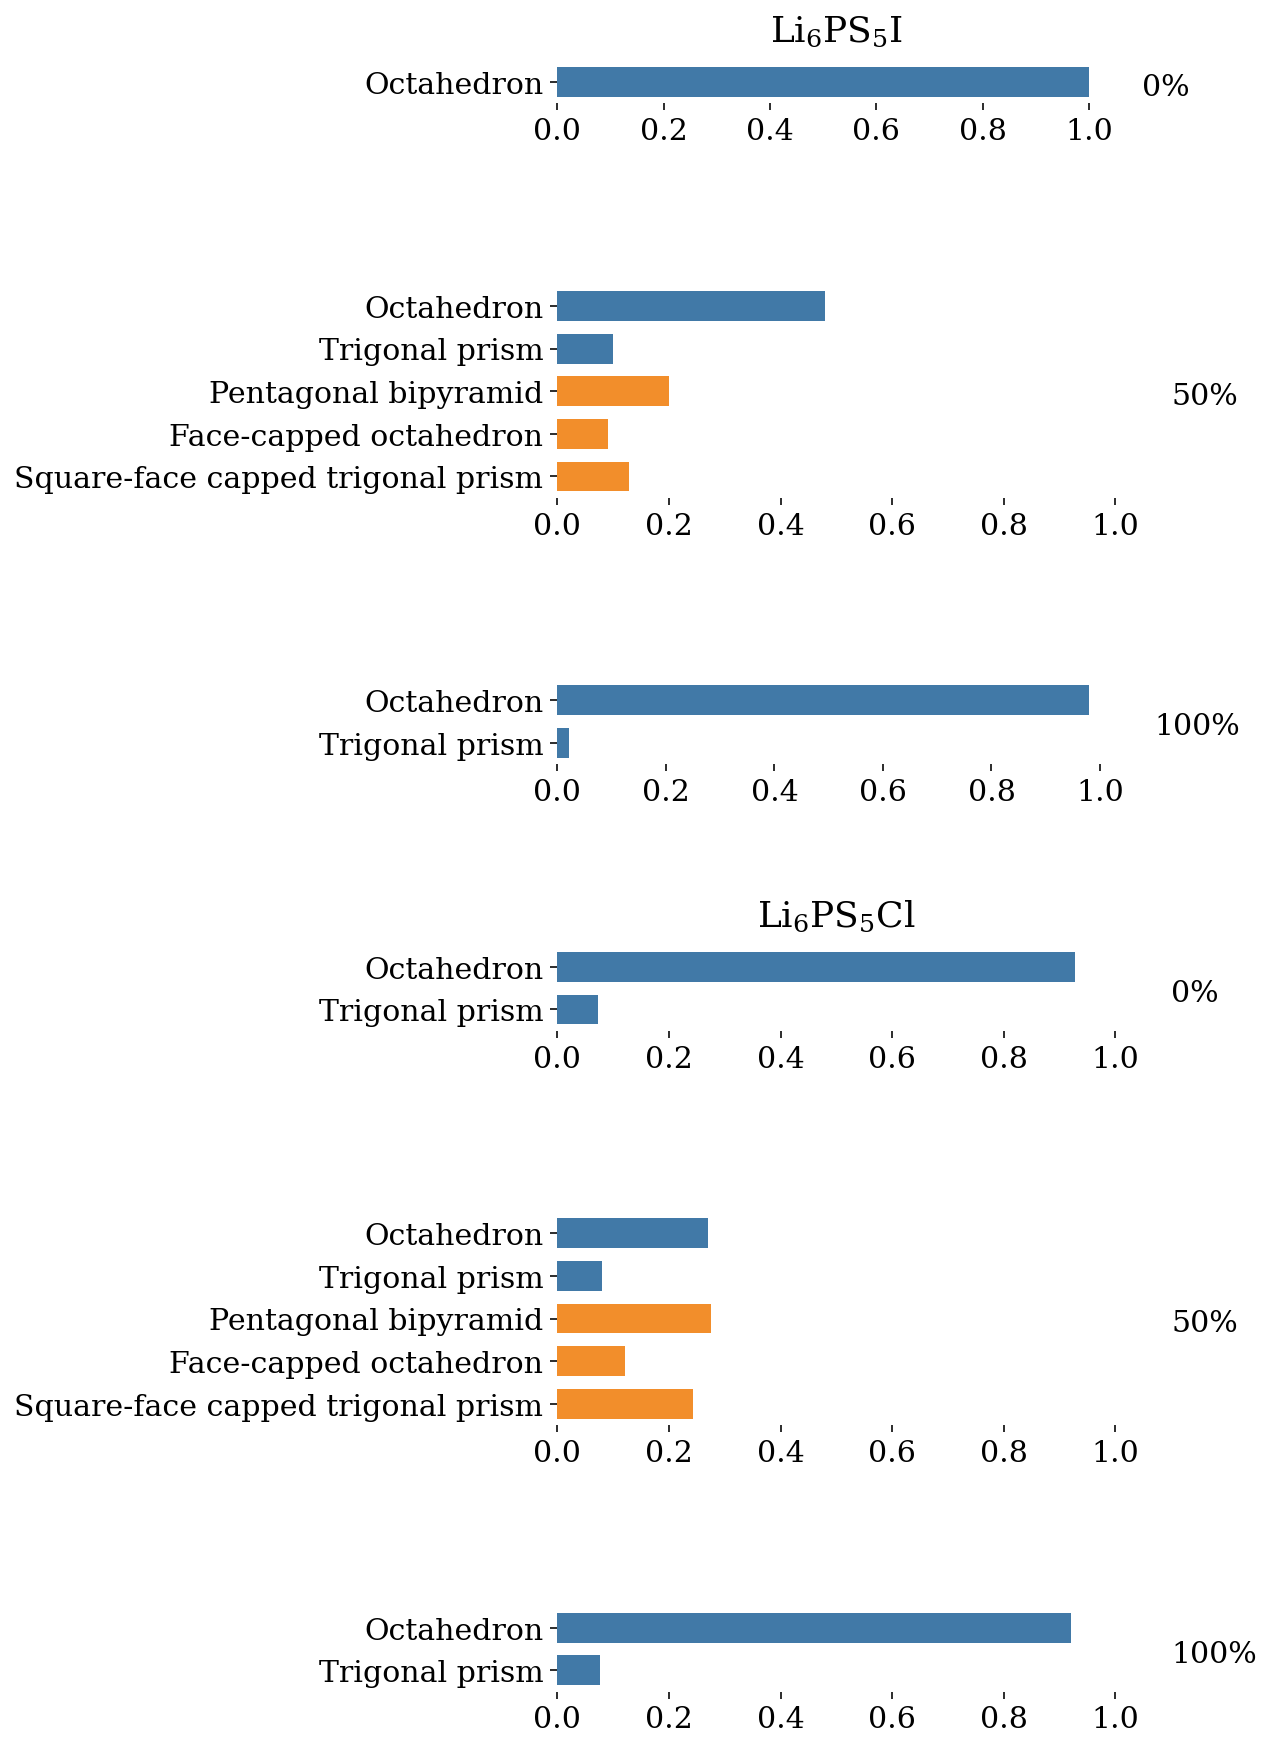

In [13]:
import warnings
warnings.filterwarnings('ignore')

order = {'Octahedron': 4, 
         'Trigonal prism': 3,
         'Pentagonal bipyramid': 2,
         'Face-capped octahedron': 1, 
         'Square-face capped trigonal prism': 0}

i = 0

c1 = '#4179a7'
c2 = '#f28e2b'
col = {'Octahedron': c1,
       'Trigonal prism': c1,
       'Pentagonal bipyramid': c2,
       'Face-capped octahedron': c2, 
       'Square-face capped trigonal prism': c2}

to_plot = {}
for system in ['Li6PS5I', 'Li6PS5Cl']:
    to_plot[system] = {}
    for disorder in ['0p', '50p', '100p']:
        threshold = 0.01
        data = bfg_data[system][disorder]
        c = Counter( g['geometry'] for g in data )
        total = sum(c.values(), 0.0)
        for key in c:
            c[key] /= total
        labels = []
        values = []
        for l, v in c.items():
            if v >= threshold:
                labels.append(l)
                values.append(v)
        labels, values = zip(*sorted(zip(labels, values), key=lambda x: order[x[0]]))
        colors = [ col[l] for l in labels ]
        to_plot[system][disorder] = {'labels': labels, 'values': values, 
                                     'n': len(values), 'colors': colors}

subplot_heights = []
for system in ['Li6PS5I', 'Li6PS5Cl']:
    for disorder in [ '0p', '50p', '100p' ]:
        subplot_heights.append(to_plot[system][disorder]['n'])
        
title = {'Li6PS5Cl': r'Li$_6$PS$_5$Cl',
         'Li6PS5I': r'Li$_6$PS$_5$I'}  
title_disorder = {'0p': '0%',
                  '50p': '50%',
                  '100p': '100%'}
fig, ax = plt.subplots(6,1 , gridspec_kw={'height_ratios': subplot_heights, 
                                         'hspace': 1.5}, figsize=(5,15) )
for system in ['Li6PS5I', 'Li6PS5Cl']:
    for disorder in ['0p', '50p', '100p']:
        p = to_plot[system][disorder]
        indexes = np.arange(len(p['labels']))
        height = 0.7

        ax[i].barh(indexes, p['values'], height, color=p['colors'], antialiased=True)
        ax[i].set_ylim([-0.5,p['n']-0.5])
        ax[i].set_yticks(indexes)
        ax[i].set_yticklabels(p['labels'])
        ax[i].set_xticks(np.linspace(0,1,6))
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        if i in  [0,3]:
            ax[i].set_title(f'{title[system]}', pad=10)
        ax[i].text(1.1,p['n']/2.0-0.8,f'{title_disorder[disorder]}')
        i+=1
fig.tight_layout()

fig.savefig('../../figures/polyhedra_types.pdf', bbox_inches='tight')
fig.show()

In [15]:
%load_ext version_information

%version_information yaml, pymatgen, tqdm, numpy, polyhedral_analysis, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.7 64bit [Clang 11.0.3 (clang-1103.0.32.62)]
IPython 7.19.0
OS Darwin 19.6.0 x86_64 i386 64bit
yaml 5.3.1
pymatgen 2020.11.11
tqdm 4.54.0
numpy 1.19.4
polyhedral_analysis 0.1
matplotlib 3.3.3
Tue Dec 08 18:10:36 2020 GMT